# Fixed DCA Strategy for SPY ETF

This version properly implements fractional share investing and tracks portfolio value.

In [71]:
import yfinance as yf
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import matplotlib.pyplot as plt
pd.options.display.max_rows = 1000

In [72]:
# Download SPY data
ticker = 'SPY'
data = yf.download(ticker, start='2010-01-01', end='2023-12-31')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.041888,85.813824,84.391037,85.768417,118944600
2010-01-05,85.715470,86.033326,85.405178,85.995483,111579900
2010-01-06,85.912251,86.267949,85.844142,86.056046,116074400
2010-01-07,85.897123,86.525271,85.654947,86.419319,131091100
2010-01-08,86.192260,86.744729,86.018199,86.706886,126402800


In [73]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy

def max_drawdown(equity_series: pd.Series) -> float:
    """
    Calculate the maximum drawdown of an equity series.
    
    Args:
        equity_series: A pandas Series of portfolio equity values.
        
    Returns:
        The maximum drawdown as a percentage.
    """
    cum_max = equity_series.cummax()
    drawdown = (equity_series - cum_max) / cum_max
    return drawdown.min() * 100  # return as percentage

def calculate_dca(tickers: list, start_date: str = '2010-01-01', end_date: str = '2023-12-31', 
                  amount: float = 10000, initialAmount = 3650000, frequency: str = '2W'):
    """
    Calculate and plot DCA performance for multiple tickers, including max drawdown.
    
    Args:
        tickers: List of ticker symbols to analyze
        start_date: Start date for backtest
        end_date: End date for backtest
        amount: Dollar amount to invest each period
        frequency: Frequency of investments (e.g., '2W' for every 2 weeks)
    """
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    
    # Store results for each ticker
    all_results = {}
    combined_equity = pd.DataFrame()  # DataFrame to store equity curves for each ticker
    
    for ticker in tickers:
        # Download data
        data = yf.download(ticker, start=start_date, end=end_date)
        data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
        
        class FixedDCAStrategy(Strategy):
            dca_amount = amount
            dca_frequency = frequency
            
            def init(self):
                super().init()
                self.trading_days = self.data.index.values
                
                self.dca_schedule = pd.date_range(
                    start=self.data.index[0],
                    end=self.data.index[-1],
                    freq=self.dca_frequency
                ).values
                
                self.valid_dca_days = []
                for dca_date in self.dca_schedule:
                    mask = self.trading_days >= dca_date
                    if any(mask):
                        valid_day = self.trading_days[mask][0]
                        self.valid_dca_days.append(valid_day)
                
                self.valid_dca_days = set(self.valid_dca_days)
                self.shares = 0.0
                self.cash = 0.0
                self.investment_dates = set()
            
            def next(self):
                current_date = self.data.index[-1].to_datetime64()
                
                if current_date in self.valid_dca_days and current_date not in self.investment_dates:
                    price = self.data.Close[-1]
                    shares_bought = self.dca_amount / price
                    
                    self.shares += shares_bought
                    self.cash -= self.dca_amount
                    self.investment_dates.add(current_date)
                    
                    whole_shares = int(shares_bought)
                    if whole_shares > 0:
                        self.buy(size=whole_shares)
        
        # Run backtest
        data.columns = data.columns.get_level_values(0)
        bt = Backtest(data, FixedDCAStrategy, commission=0, cash=initialAmount, exclusive_orders=False)
        stats = bt.run()
        
        
        print(stats)
        
        # Calculate performance metrics
        total_investments = len(stats['_strategy'].valid_dca_days)
        total_invested = total_investments * amount
        final_value = stats['Equity Final [$]']
        profit = final_value - total_invested
        profit_pct = (profit / total_invested) * 100
        
        # Calculate max drawdown for this ticker
        equity_curve = stats['_equity_curve']['Equity']
        ticker_max_dd = max_drawdown(equity_curve)
        
        # Store results
        all_results[ticker] = {
            'total_investments': total_investments,
            'total_invested': total_invested,
            'final_value': final_value,
            'profit': profit,
            'profit_pct': profit_pct,
            'max_drawdown': ticker_max_dd,
            'equity_curve': stats['_equity_curve']
        }
        
        # Plot individual equity curve
        equity_curve.plot(ax=ax, label=f'{ticker} DCA', alpha=0.7)
        
        # Add equity curve to combined_equity DataFrame
        combined_equity[ticker] = equity_curve

    # Align all equity curves to a common index and forward-fill missing values
    combined_equity = combined_equity.sort_index().ffill()
    
    # Calculate and plot combined performance (total portfolio performance)
    if len(tickers) > 1:
        combined_equity['Combined'] = combined_equity.sum(axis=1)
        combined_equity['Combined'].plot(ax=ax, label='Combined Portfolio', color='black', linewidth=2, linestyle='--')
    
    # Format plot
    plt.title(f'DCA Strategy Performance (${amount:,.0f} every {frequency})')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.ticklabel_format(axis='y', style='plain')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    # Print results for each ticker
    for ticker, res in all_results.items():
        print(f"\n{ticker} Results:")
        print(f"Total Investments Made: {res['total_investments']}")
        print(f"Total Invested: ${res['total_invested']:,.2f}")
        print(f"Final Portfolio Value: ${res['final_value']:,.2f}")
        print(f"Total Profit: ${res['profit']:,.2f}")
        print(f"Return: {res['profit_pct']:.2f}%")
        print(f"Max Drawdown: {res['max_drawdown']:.2f}%")
    
    if len(tickers) > 1:
        # Sum investments and use total combined equity for overall portfolio performance
        combined_invested = sum(res['total_invested'] for res in all_results.values())
        combined_final = combined_equity['Combined'].iloc[-1]
        combined_profit = combined_final - combined_invested
        combined_pct = (combined_profit / combined_invested) * 100
        
        # Calculate combined max drawdown on cleaned data
        combined_max_dd = max_drawdown(combined_equity['Combined'])
        
        print("\nCombined Portfolio Results:")
        print(f"Total Investments Made: {all_results[tickers[0]]['total_investments']} per ticker")
        print(f"Total Invested: ${combined_invested:,.2f} (total across tickers)")
        print(f"Final Portfolio Value: ${combined_final:,.2f}")
        print(f"Total Profit: ${combined_profit:,.2f}")
        print(f"Return: {combined_pct:.2f}%")
        print(f"Max Drawdown: {combined_max_dd:.2f}%")
    
    plt.show()
    # return all_results


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Start                     2010-01-04 00:00:00
End                       2025-03-26 00:00:00
Duration                   5560 days 00:00:00
Exposure Time [%]                   99.843383
Equity Final [$]              12159542.396247
Equity Peak [$]                12914181.01182
Return [%]                         206.285703
Buy & Hold Return [%]              568.450953
Return (Ann.) [%]                    7.640824
Volatility (Ann.) [%]               12.474838
Sharpe Ratio                         0.612499
Sortino Ratio                        0.922629
Calmar Ratio                          0.28084
Max. Drawdown [%]                  -27.207069
Avg. Drawdown [%]                   -0.941974
Max. Drawdown Duration      707 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                                  397
Win Rate [%]                        97.229219
Best Trade [%]                     611.019603
Worst Trade [%]                     -5.435303
Avg. Trade [%]                    

Start                     2010-01-04 00:00:00
End                       2025-03-26 00:00:00
Duration                   5560 days 00:00:00
Exposure Time [%]                   99.843301
Equity Final [$]               7793839.420532
Equity Peak [$]                 7828955.89978
Return [%]                          96.318373
Buy & Hold Return [%]              170.475103
Return (Ann.) [%]                     4.53959
Volatility (Ann.) [%]                 8.76828
Sharpe Ratio                         0.517729
Sortino Ratio                          0.7706
Calmar Ratio                         0.270734
Max. Drawdown [%]                  -16.767743
Avg. Drawdown [%]                   -1.573188
Max. Drawdown Duration     2872 days 00:00:00
Avg. Drawdown Duration       63 days 00:00:00
# Trades                                  397
Win Rate [%]                            100.0
Best Trade [%]                     182.521013
Worst Trade [%]                      0.645295
Avg. Trade [%]                    

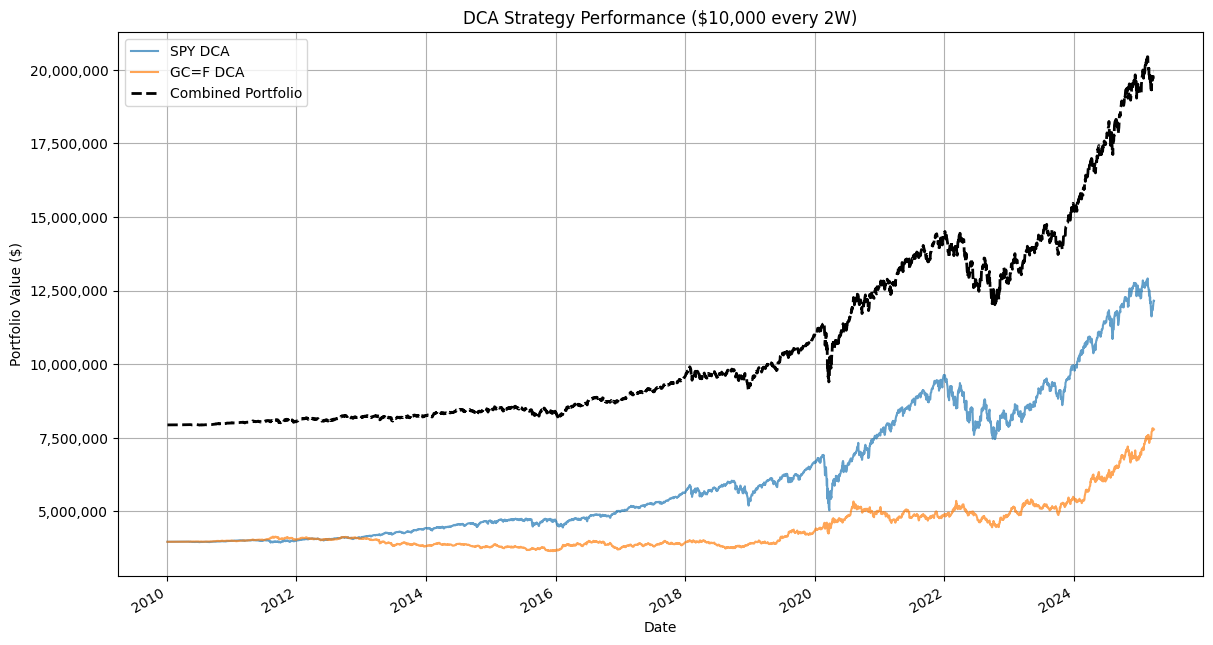

In [74]:
calculate_dca(['SPY', 'GC=F'], '2010-01-01', None, 10000, 3970000, '2W')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Start                     2010-01-04 00:00:00
End                       2025-03-26 00:00:00
Duration                   5560 days 00:00:00
Exposure Time [%]                   99.843383
Equity Final [$]              12159542.427656
Equity Peak [$]                12914181.04323
Return [%]                         206.285703
Buy & Hold Return [%]              568.439342
Return (Ann.) [%]                    7.640824
Volatility (Ann.) [%]               12.474843
Sharpe Ratio                         0.612499
Sortino Ratio                        0.922629
Calmar Ratio                          0.28084
Max. Drawdown [%]                  -27.207058
Avg. Drawdown [%]                   -0.941974
Max. Drawdown Duration      707 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                                  397
Win Rate [%]                        97.229219
Best Trade [%]                     611.019805
Worst Trade [%]                     -5.435303
Avg. Trade [%]                    


[*********************100%***********************]  1 of 1 completed

Start                     2010-01-04 00:00:00
End                       2025-03-26 00:00:00
Duration                   5560 days 00:00:00
Exposure Time [%]                   99.843301
Equity Final [$]               7793839.420532
Equity Peak [$]                 7828955.89978
Return [%]                          96.318373
Buy & Hold Return [%]              170.475103
Return (Ann.) [%]                     4.53959
Volatility (Ann.) [%]                 8.76828
Sharpe Ratio                         0.517729
Sortino Ratio                          0.7706
Calmar Ratio                         0.270734
Max. Drawdown [%]                  -16.767743
Avg. Drawdown [%]                   -1.573188
Max. Drawdown Duration     2872 days 00:00:00
Avg. Drawdown Duration       63 days 00:00:00
# Trades                                  397
Win Rate [%]                            100.0
Best Trade [%]                     182.521013
Worst Trade [%]                      0.645295
Avg. Trade [%]                    

Start                     2010-01-04 00:00:00
End                       2025-03-26 00:00:00
Duration                   5560 days 00:00:00
Exposure Time [%]                   99.843383
Equity Final [$]              14048178.121368
Equity Peak [$]               14048178.121368
Return [%]                         253.858391
Buy & Hold Return [%]              703.971617
Return (Ann.) [%]                    8.667969
Volatility (Ann.) [%]               13.554498
Sharpe Ratio                          0.63949
Sortino Ratio                        1.020922
Calmar Ratio                          0.35381
Max. Drawdown [%]                  -24.498926
Avg. Drawdown [%]                   -1.574166
Max. Drawdown Duration      622 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                  397
Win Rate [%]                            100.0
Best Trade [%]                     701.872531
Worst Trade [%]                      1.056235
Avg. Trade [%]                    

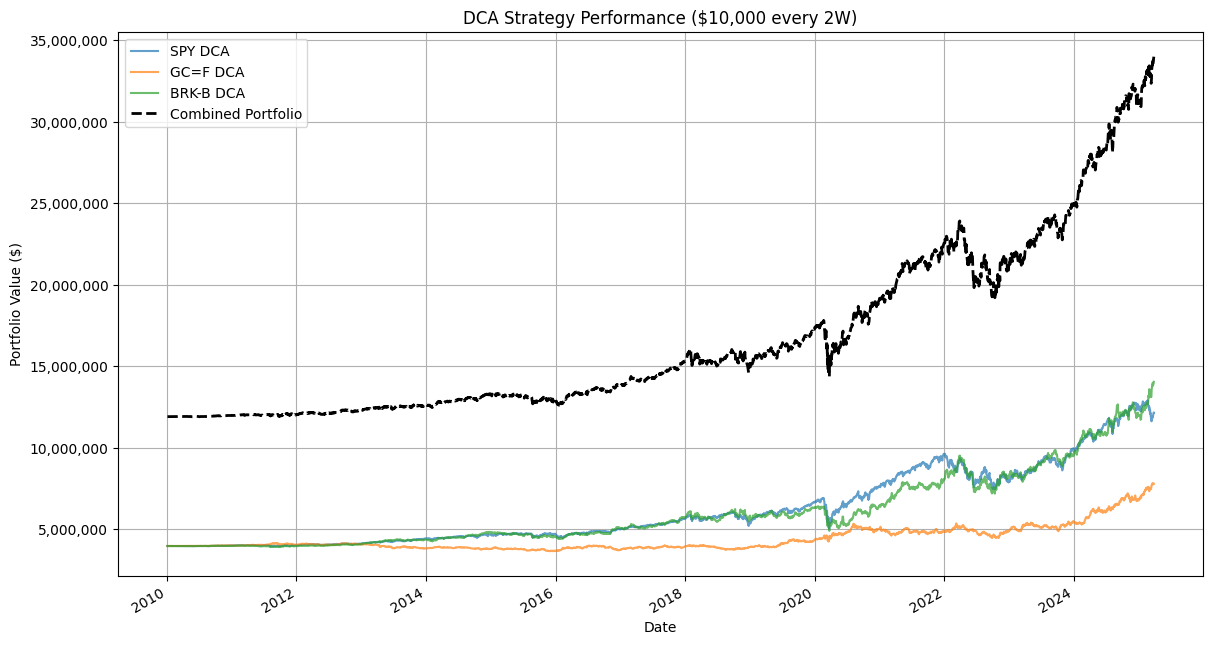

In [75]:
calculate_dca(['SPY', 'GC=F', 'BRK-B'], '2010-01-01', None, 10000, 3970000, '2W')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Start                     2010-01-04 00:00:00
End                       2025-03-26 00:00:00
Duration                   5560 days 00:00:00
Exposure Time [%]                   99.843383
Equity Final [$]              12159542.424587
Equity Peak [$]                12914181.04016
Return [%]                         206.285703
Buy & Hold Return [%]              568.451132
Return (Ann.) [%]                    7.640824
Volatility (Ann.) [%]               12.474835
Sharpe Ratio                         0.612499
Sortino Ratio                        0.922629
Calmar Ratio                          0.28084
Max. Drawdown [%]                  -27.207056
Avg. Drawdown [%]                   -0.941974
Max. Drawdown Duration      707 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                                  397
Win Rate [%]                        97.229219
Best Trade [%]                     611.019805
Worst Trade [%]                     -5.435303
Avg. Trade [%]                    


[*********************100%***********************]  1 of 1 completed

Start                     2010-01-04 00:00:00
End                       2025-03-26 00:00:00
Duration                   5560 days 00:00:00
Exposure Time [%]                   99.843383
Equity Final [$]              14048178.121368
Equity Peak [$]               14048178.121368
Return [%]                         253.858391
Buy & Hold Return [%]              703.971617
Return (Ann.) [%]                    8.667969
Volatility (Ann.) [%]               13.554498
Sharpe Ratio                          0.63949
Sortino Ratio                        1.020922
Calmar Ratio                          0.35381
Max. Drawdown [%]                  -24.498926
Avg. Drawdown [%]                   -1.574166
Max. Drawdown Duration      622 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                  397
Win Rate [%]                            100.0
Best Trade [%]                     701.872531
Worst Trade [%]                      1.056235
Avg. Trade [%]                    

Start                     2010-09-09 00:00:00
End                       2025-03-26 00:00:00
Duration                   5312 days 00:00:00
Exposure Time [%]                    99.91801
Equity Final [$]              11186530.980478
Equity Peak [$]               11869782.859018
Return [%]                         181.776599
Buy & Hold Return [%]              580.289358
Return (Ann.) [%]                    7.395362
Volatility (Ann.) [%]               12.180383
Sharpe Ratio                         0.607153
Sortino Ratio                        0.913189
Calmar Ratio                         0.283771
Max. Drawdown [%]                  -26.061031
Avg. Drawdown [%]                   -0.874114
Max. Drawdown Duration      707 days 00:00:00
Avg. Drawdown Duration       17 days 00:00:00
# Trades                                  380
Win Rate [%]                        97.368421
Best Trade [%]                     572.554348
Worst Trade [%]                     -4.248327
Avg. Trade [%]                    

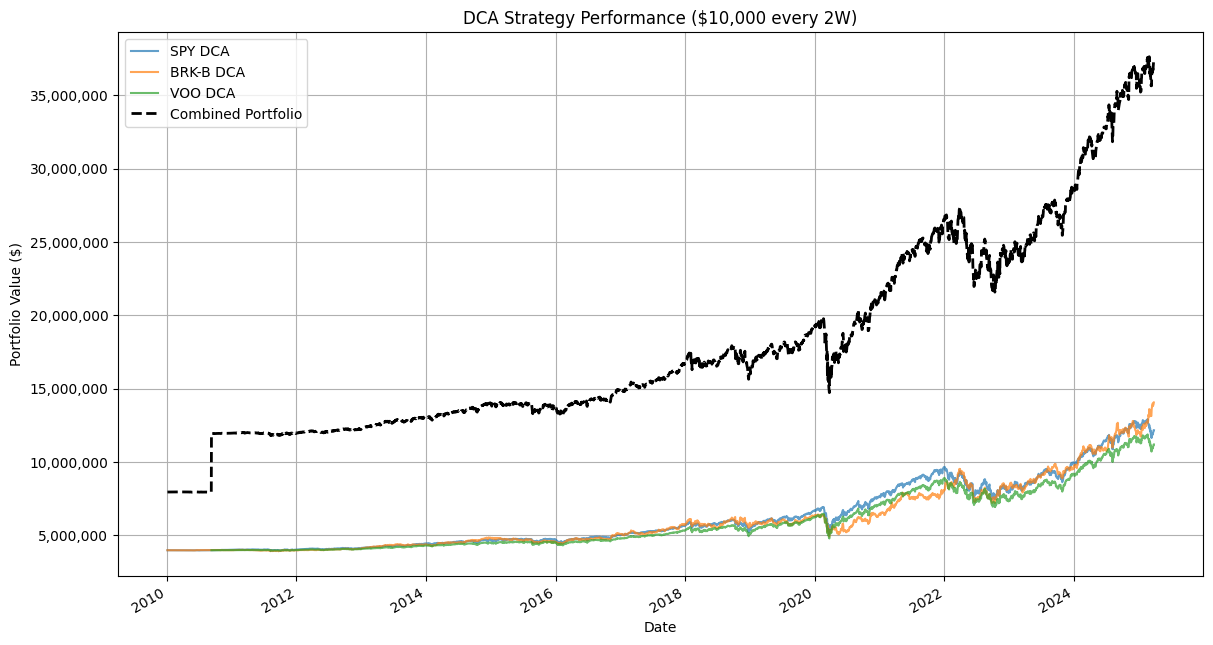

In [76]:
calculate_dca(['SPY', 'BRK-B', 'VOO'], '2010-01-01', None, 10000, 3970000, '2W')

[*********************100%***********************]  1 of 1 completed


Start                     2023-02-07 00:00:00
End                       2025-03-26 00:00:00
Duration                    778 days 00:00:00
Exposure Time [%]                   99.065421
Equity Final [$]                 669184.40245
Equity Peak [$]                 728979.752681
Return [%]                          19.497215
Buy & Hold Return [%]               47.744033
Return (Ann.) [%]                    8.752108
Volatility (Ann.) [%]               10.946467
Sharpe Ratio                         0.799537
Sortino Ratio                        1.196229
Calmar Ratio                         0.696188
Max. Drawdown [%]                   -12.57148
Avg. Drawdown [%]                   -1.189199
Max. Drawdown Duration      118 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                                   56
Win Rate [%]                        80.357143
Best Trade [%]                      59.582171
Worst Trade [%]                     -6.983105
Avg. Trade [%]                    

[*********************100%***********************]  1 of 1 completed

Start                     2023-02-07 00:00:00
End                       2025-03-26 00:00:00
Duration                    778 days 00:00:00
Exposure Time [%]                   99.065421
Equity Final [$]                664400.101551
Equity Peak [$]                 703201.531423
Return [%]                          18.642875
Buy & Hold Return [%]               42.410211
Return (Ann.) [%]                     8.38518
Volatility (Ann.) [%]                8.673387
Sharpe Ratio                         0.966771
Sortino Ratio                        1.454576
Calmar Ratio                         0.878808
Max. Drawdown [%]                   -9.541544
Avg. Drawdown [%]                   -0.818581
Max. Drawdown Duration      107 days 00:00:00
Avg. Drawdown Duration       13 days 00:00:00
# Trades                                   56
Win Rate [%]                        82.142857
Best Trade [%]                      51.908202
Worst Trade [%]                     -4.253539
Avg. Trade [%]                    

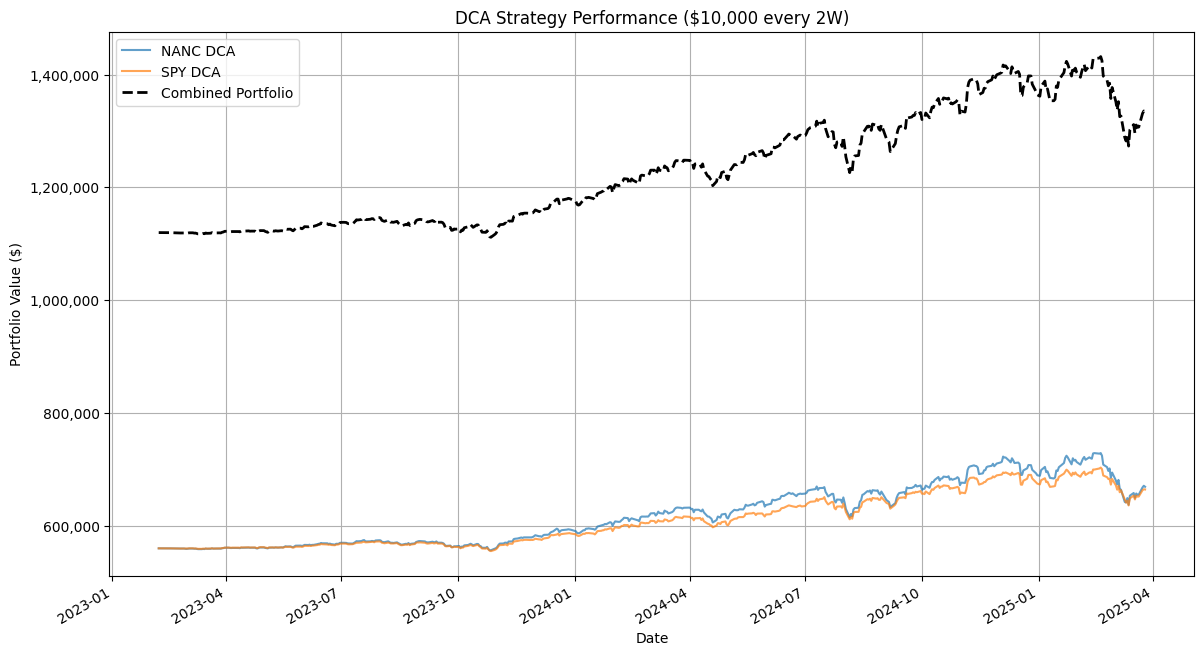

In [77]:
calculate_dca(['NANC', 'SPY'], '2023-02-07', None, 10000, 560000, '2W')

[*********************100%***********************]  1 of 1 completed


Start                     1980-02-07 00:00:00
End                       2025-03-26 00:00:00
Duration                  16484 days 00:00:00
Exposure Time [%]                   99.973629
Equity Final [$]             119144461.096001
Equity Peak [$]              126833766.924614
Return [%]                        1716.226541
Buy & Hold Return [%]             4851.436056
Return (Ann.) [%]                    6.633339
Volatility (Ann.) [%]               16.690199
Sharpe Ratio                         0.397439
Sortino Ratio                        0.599096
Calmar Ratio                         0.116864
Max. Drawdown [%]                  -56.761184
Avg. Drawdown [%]                   -1.677243
Max. Drawdown Duration     2597 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                  676
Win Rate [%]                            100.0
Best Trade [%]                    5718.792231
Worst Trade [%]                    188.477716
Avg. Trade [%]                    

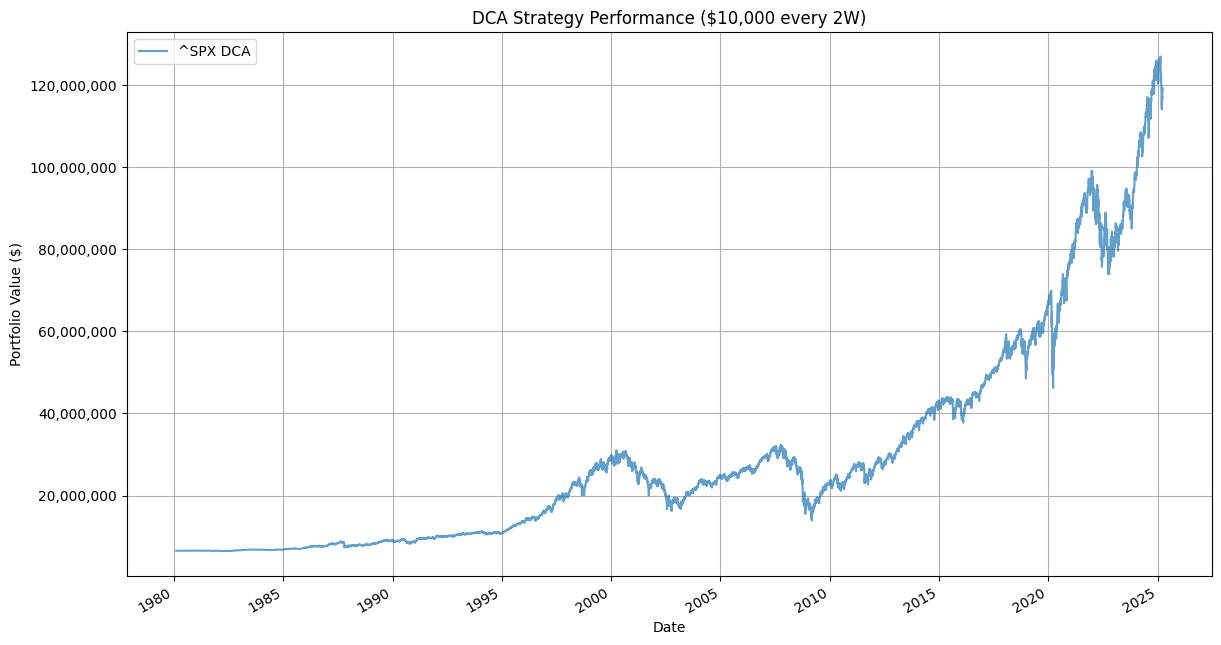

In [93]:
calculate_dca(['^SPX'], '1980-02-07', None, 10000, 6560000, '2W')